# Red neuronal regresión con datos numéricos
En ese notebook usaremos una red neuronal de regresión para predecir el precio de los apartamentos sin tener en cuenta las imágenes, solo se usará datos numéricos.

El primer paso será cargar dos datasets de train y test y hacer el escalado de características

## Carga de datos y escalado

In [ ]:
import tensorflow as tf

tf.enable_eager_execution()

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
print( tf.constant( 'Hellow from TensorFlow ' + tf.__version__ ) )

In [1]:
import pandas as pd
import os
from sklearn import preprocessing

# Carga el dataset y devuelve un dataframe de Pandas
def load_airbnb_dataset(ruta,nombre):
    csv_path = os.path.join(ruta, nombre)
    return pd.read_csv(csv_path, sep=';')

In [2]:
copTrain = load_airbnb_dataset('datasets', 'trainFinal.csv')
copTest = load_airbnb_dataset('datasets', 'testFinal.csv')

# Separo la Y del resto de datos
dataPrecio = copTrain['Price']
dataSinPrecio = copTrain.drop(['Price'], axis=1, inplace=False)

dataPrecioTest = copTest['Price']
dataSinPrecioTest = copTest.drop(['Price'], axis=1, inplace=False)

y_train = dataPrecio.values
X_train = dataSinPrecio.values

y_test = dataPrecioTest.values
X_test = dataSinPrecioTest.values

feature_names = copTrain.columns[:]

# Obtener precio máximo en Train, y escalamos los precios de test y train en rango de [0, 1]
maxPrice = copTrain["Price"].max()
trainY = copTrain["Price"] / maxPrice
testY = copTest["Price"] / maxPrice

# Se escala variables numéricas de train y test
scaler = preprocessing.StandardScaler().fit(X_test)
XtestScaled = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)


## Red neuronal
En este caso, usaremos una red neuronal (MLP) Multiplayer Perceptron

In [3]:
# Núemero de características
XtrainScaled.shape

(8262, 97)

Para calcular el nº de neuronas por capa oculta, uso la **Regla de la pirámide geométrica**.

Tenemos 97 características (97 neuronas de entrada).
Al ser un problema de regresión, tenemos una neurona de salida.

Dividiré por 3 capas ocultas de la siguiente forma:

r = raíz cuarta de 97/1
r = 3

h1 = 1 * 3^3 = 27
h2 = 1 * 3^2 = 9
h3 = 1 * 3 = 3

In [12]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(27, input_dim=dim, activation="relu"))
	model.add(Dense(9, activation="relu"))
	model.add(Dense(3, activation="relu"))
	model.add(Dense(1, activation="linear"))
	
	return model

In [13]:
model = create_mlp(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

historico = model.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
	epochs=200, batch_size=27)

===============] - 1s 117us/step - loss: 47.1708 - val_loss: 47.9046
Epoch 18/200
8262/8262 [==============================] - 1s 122us/step - loss: 47.1888 - val_loss: 47.8500
Epoch 19/200
8262/8262 [==============================] - 1s 123us/step - loss: 47.1680 - val_loss: 47.9451
Epoch 20/200
8262/8262 [==============================] - 1s 127us/step - loss: 47.2050 - val_loss: 47.8227
Epoch 21/200
8262/8262 [==============================] - 1s 125us/step - loss: 47.2631 - val_loss: 48.1704
Epoch 22/200
8262/8262 [==============================] - 1s 120us/step - loss: 46.6732 - val_loss: 45.3766
Epoch 23/200
8262/8262 [==============================] - 1s 121us/step - loss: 35.0523 - val_loss: 35.7290
Epoch 24/200
8262/8262 [==============================] - 1s 120us/step - loss: 29.2326 - val_loss: 33.8364
Epoch 25/200
8262/8262 [==============================] - 1s 117us/step - loss: 27.4172 - val_loss: 32.2844
Epoch 26/200
8262/8262 [==============================] - 1s 117us/

Como se puede observar, al final se obtiene un 15% de error de train y un 34% de test, por lo que se encuentra en overfitting porque no está generalizando bien. Se prueba el cambio de la función de activación a Selu para ver si mejora.

In [14]:
def create_mlp_Selu(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(27, input_dim=dim, activation="selu"))
	model.add(Dense(9, activation="selu"))
	model.add(Dense(3, activation="selu"))
	model.add(Dense(1, activation="linear"))
	
	return model

In [15]:
model = create_mlp_Selu(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

historico = model.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
	epochs=200, batch_size=27)

4.1443 - val_loss: 31.6921
Epoch 17/200
8262/8262 [==============================] - 1s 120us/step - loss: 23.7927 - val_loss: 29.4464
Epoch 18/200
8262/8262 [==============================] - 1s 119us/step - loss: 23.6123 - val_loss: 31.7597
Epoch 19/200
8262/8262 [==============================] - 1s 119us/step - loss: 23.4813 - val_loss: 30.4144
Epoch 20/200
8262/8262 [==============================] - 1s 120us/step - loss: 23.7792 - val_loss: 30.0129
Epoch 21/200
8262/8262 [==============================] - 1s 119us/step - loss: 23.2793 - val_loss: 29.9949
Epoch 22/200
8262/8262 [==============================] - 1s 119us/step - loss: 23.2477 - val_loss: 29.7395
Epoch 23/200
8262/8262 [==============================] - 1s 119us/step - loss: 22.9522 - val_loss: 29.4874
Epoch 24/200
8262/8262 [==============================] - 1s 120us/step - loss: 22.8835 - val_loss: 29.4174
Epoch 25/200
8262/8262 [==============================] - 1s 120us/step - loss: 22.7446 - val_loss: 30.6311
E

Se mantiene en overfitting y se obtiene un peor resultado del modelo, por lo que ajustaré las capas ocultas.

In [10]:
def create_mlp_Relu_2(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(25, input_dim=dim, activation="relu"))
	model.add(Dense(5, activation="relu"))
	model.add(Dense(1, activation="linear"))
	
	return model

In [11]:
model = create_mlp_Relu_2(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

historico = model.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
	epochs=200, batch_size=8)

1.8309 - val_loss: 28.1191
Epoch 17/200
8262/8262 [==============================] - 3s 323us/step - loss: 21.4075 - val_loss: 28.1380
Epoch 18/200
8262/8262 [==============================] - 3s 324us/step - loss: 21.5085 - val_loss: 28.5800
Epoch 19/200
8262/8262 [==============================] - 3s 324us/step - loss: 21.2940 - val_loss: 28.0959
Epoch 20/200
8262/8262 [==============================] - 3s 325us/step - loss: 20.8887 - val_loss: 28.7161
Epoch 21/200
8262/8262 [==============================] - 3s 324us/step - loss: 20.7360 - val_loss: 28.9526
Epoch 22/200
8262/8262 [==============================] - 3s 322us/step - loss: 20.5571 - val_loss: 28.4991
Epoch 23/200
8262/8262 [==============================] - 3s 327us/step - loss: 20.4951 - val_loss: 28.4406
Epoch 24/200
8262/8262 [==============================] - 3s 321us/step - loss: 20.4313 - val_loss: 28.6592
Epoch 25/200
8262/8262 [==============================] - 3s 323us/step - loss: 20.1866 - val_loss: 29.3595
E

Se disminuye una capa más y se añade una de batch normalization

In [27]:
from keras.layers.normalization import BatchNormalization

def create_mlp_Relu_3(dim):
    # define our MLP network
    model = Sequential()
    model.add(Dense(10, input_dim=dim, activation="relu"))    
    model.add(BatchNormalization())
    model.add(Dense(1, activation="linear"))
        
    return model

In [31]:
modelUnaCapa = create_mlp_Relu_3(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
modelUnaCapa.compile(loss="mean_absolute_percentage_error", optimizer=opt)

historicoUnaCapa = modelUnaCapa.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
	epochs=200, batch_size=8)

0.7726 - val_loss: 29.2804
Epoch 17/200
8262/8262 [==============================] - 4s 467us/step - loss: 30.5551 - val_loss: 30.6587
Epoch 18/200
8262/8262 [==============================] - 4s 471us/step - loss: 30.2589 - val_loss: 29.8637
Epoch 19/200
8262/8262 [==============================] - 4s 471us/step - loss: 30.3413 - val_loss: 30.1679
Epoch 20/200
8262/8262 [==============================] - 4s 468us/step - loss: 30.2665 - val_loss: 31.8584
Epoch 21/200
8262/8262 [==============================] - 4s 469us/step - loss: 30.4152 - val_loss: 30.6798
Epoch 22/200
8262/8262 [==============================] - 4s 469us/step - loss: 30.0497 - val_loss: 29.8083
Epoch 23/200
8262/8262 [==============================] - 4s 468us/step - loss: 29.9273 - val_loss: 31.5020
Epoch 24/200
8262/8262 [==============================] - 4s 469us/step - loss: 30.0411 - val_loss: 29.7581
Epoch 25/200
8262/8262 [==============================] - 4s 457us/step - loss: 29.8163 - val_loss: 30.6721
E

Se observa que al añadir la capa de batch normalization se concluye con overfitting, pero con un error alto, 27% en train y 31% en test. Voy a volver al estado anterior del principio pero añadiendo batch normalization con el de ver si baja el error.

In [32]:
def create_mlp_fin(dim):
    # define our MLP network
    model = Sequential()
    model.add(Dense(27, input_dim=dim, activation="relu"))
    model.add(Dense(9, activation="relu"))
    model.add(Dense(3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="linear"))

    return model

In [33]:
model = create_mlp_fin(XtrainScaled.shape[1])
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

historico = model.fit(XtrainScaled, trainY, validation_data=(XtestScaled, testY),
	epochs=200, batch_size=8)

3.1230 - val_loss: 32.7745
Epoch 17/200
8262/8262 [==============================] - 4s 540us/step - loss: 32.1331 - val_loss: 32.7570
Epoch 18/200
8262/8262 [==============================] - 4s 543us/step - loss: 32.4637 - val_loss: 37.7057
Epoch 19/200
8262/8262 [==============================] - 4s 541us/step - loss: 31.8141 - val_loss: 34.1714
Epoch 20/200
8262/8262 [==============================] - 4s 536us/step - loss: 31.3517 - val_loss: 31.9398
Epoch 21/200
8262/8262 [==============================] - 4s 534us/step - loss: 31.7228 - val_loss: 30.9845
Epoch 22/200
8262/8262 [==============================] - 4s 538us/step - loss: 31.1874 - val_loss: 35.9751
Epoch 23/200
8262/8262 [==============================] - 4s 542us/step - loss: 30.9286 - val_loss: 31.0311
Epoch 24/200
8262/8262 [==============================] - 4s 535us/step - loss: 30.7966 - val_loss: 30.7830
Epoch 25/200
8262/8262 [==============================] - 4s 539us/step - loss: 30.3760 - val_loss: 31.3245
E

He bajado el error, pero la diferencia entre train y test vuelve a ser algo alta, así que me quedo con el modelo de una capa única.

## Curva de pérdidas de los datos de train(solo una capa oculta)

Text(0, 0.5, 'Loss')

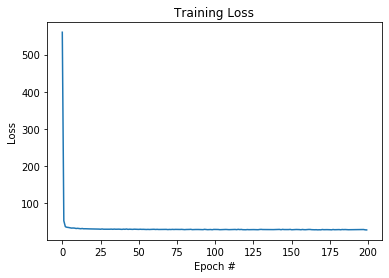

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 200), historicoUnaCapa.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

# Evaluación del modelo
Una vez obtenido el modelo entrenado, ahora se evalua y se observa el resumen de resultados

In [40]:
import locale

preds = modelUnaCapa.predict(XtestScaled)

# Cargar dataset original
df = load_airbnb_dataset('datasets', 'datasetImagenesFinal.csv')

# Comprobar la diferencia entre los percios que ha predecido con los que tenemos en el dataset
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# Calculamos la media y la desviación estándar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# Vemos las estadísticas
locale.setlocale(locale.LC_ALL, "es_ES.UTF-8")
print("[INFO] media precio apartamento: {}, desviación precio apartamento: {}".format(
	locale.currency(df["Price"].mean(), grouping=True),
	locale.currency(df["Price"].std(), grouping=True)))
print("[INFO] media: {:.2f}%, desviación: {:.2f}%".format(mean, std))

[INFO] media precio apartamento: 68,24 €, desviación precio apartamento: 68,01 €
[INFO] media: 30.73%, desviación: 23.42%


# Resultados

La red neuronal en este ejercicio resulta con una pérdida 27,6% en train y un 30,7% en test.

Por otro lado, el cálculo de error absoluto es del 30,73% lo que significa que el promedio de la red tendrá un 30% de error en las predicciones de los precios de los apartamentos con una desviación del 23%.